In [66]:
import pandas as pd

# Replace with the actual file paths to your parquet files
df_30s = pd.read_parquet('df_30s.parquet')
df_60s = pd.read_parquet('df_60s.parquet')

# Sanity check
print("df_30s:", df_30s.shape)
df_30s.head()




df_30s: (1368000, 20)


,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000072,0.000300,-0.002023,0.005951,0.001607,0.370714,0.102052,7107.0,2.281320,0.000486,-0.000097,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,30,0.000015,0.000409,0.000440,0.008193,0.002206,0.382667,0.089951,17783.0,5.571606,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,60,-0.000020,0.000258,-0.000586,0.005349,0.001391,0.304000,0.098040,7844.0,5.975772,0.000334,-0.000207,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,90,0.000030,0.000182,0.000898,0.003616,0.000996,0.306500,0.159914,10877.0,6.003413,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,120,0.000036,0.000211,0.001094,0.004162,0.001156,0.367000,-0.026375,9224.0,2.293206,0.000315,-0.000006,2021-01-05,11:00:00,1,1,Monday,1


In [67]:
print("df_60s:", df_60s.shape)
df_60s.head()

df_60s: (684000, 20)


,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,24890.0,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,18721.0,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,18513.0,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,35827.0,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,41679.0,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1


In [68]:
df_60s.dtypes

stock_id               float64
time_id                float64
bucket_start             int64
log_ret_mean           float64
log_ret_std            float64
log_ret_sum            float64
abs_volatility         float64
realized_volatility    float64
spread                 float64
imbalance              float64
depth                  float64
depth_ratio            float64
rv_rolling             float64
mom_rolling            float64
date                    object
time                    object
day                      int64
day_of_week              int64
day_name                object
week                     int64
dtype: object

In [69]:
df_60s

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,24890.0,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,18721.0,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,18513.0,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,35827.0,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,41679.0,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,104919.0,1187.0,3300,-0.000011,0.000061,-0.000685,0.002559,0.000473,0.021667,-0.040270,301254.0,1.174866,0.000070,-0.000014,2021-10-05,16:00:00,190,5,Friday,38
683996,104919.0,1187.0,3360,0.000003,0.000040,0.000154,0.001720,0.000309,0.020667,0.131692,329777.0,1.540810,0.000038,0.000011,2021-10-05,16:00:00,190,5,Friday,38
683997,104919.0,1187.0,3420,0.000007,0.000060,0.000419,0.002265,0.000468,0.021833,0.094141,416248.0,1.548123,0.000054,0.000034,2021-10-05,16:00:00,190,5,Friday,38
683998,104919.0,1187.0,3480,-0.000009,0.000059,-0.000531,0.002406,0.000459,0.021833,-0.013711,380014.0,1.346906,0.000046,-0.000011,2021-10-05,16:00:00,190,5,Friday,38


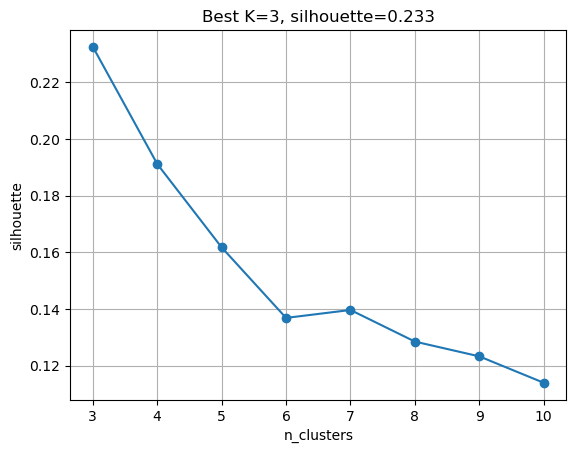

cluster
0    154
1    101
2    125
Name: count, dtype: int64
   stock_id  week  cluster
0    8382.0     1        1
1    8382.0     2        1
2    8382.0     3        1
3    8382.0     4        1
4    8382.0     5        1


In [70]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import MiniRocketMultivariate
import matplotlib.pyplot as plt

# ── 0) Filter to Monday–Thursday via day_of_week (0–3) ──────────────────────────
train = df_60s[df_60s['day_of_week'].isin([1,2,3,4])]
test = df_60s[df_60s['day_of_week'] == 5]

# ── 1) Build 3D array of multivariate series (n_series × n_buckets × n_features) ─
features = [
    "log_ret_mean","realized_volatility",
    "spread", "imbalance", "rv_rolling"
]

# aggregate duplicates
df_agg = (
    train
    .groupby(['stock_id','week','bucket_start'])[features]
    .mean()
    .reset_index()
)

# unique (stock,week) index
series_index = df_agg[['stock_id','week']].drop_duplicates().set_index(['stock_id','week'])
n_series = len(series_index)
buckets = sorted(df_agg['bucket_start'].unique())
n_buckets = len(buckets)
n_features = len(features)

# fill array
X = np.zeros((n_series, n_buckets, n_features))
for idx, (stock, wk) in enumerate(series_index.index):
    sub = df_agg[(df_agg.stock_id==stock)&(df_agg.week==wk)].set_index('bucket_start').reindex(buckets).fillna(0)
    X[idx] = sub[features].values

# ── 2) Standardize each feature channel globally ─────────────────────────────────
flat = X.reshape(-1, n_features)
scaler = StandardScaler().fit(flat)
X_scaled = scaler.transform(flat).reshape(n_series, n_buckets, n_features)

# ── 3) MiniRocketMultivariate embedding ────────────────────────────────────────
X_mr = X_scaled.transpose(0,2,1)        # → (n_series, n_features, n_buckets)
mr = MiniRocketMultivariate(random_state=0)
mr.fit(X_mr)
X_feat = mr.transform(X_mr)             # → (n_series, n_rocket_features)

# ── 4) Auto-select K by silhouette ──────────────────────────────────────────────
best_k, best_s = None, -1
scores = []
max_k = min(10, int(np.sqrt(n_series)))
for k in range(3, max_k+1):
    lbl = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(X_feat)
    s = silhouette_score(X_feat, lbl)
    scores.append((k,s))
    if s>best_s:
        best_k, best_s = k, s

# plot
ks, ss = zip(*scores)
plt.plot(ks, ss, 'o-')
plt.xlabel('n_clusters'); plt.ylabel('silhouette'); plt.grid(True)
plt.title(f'Best K={best_k}, silhouette={best_s:.3f}')
plt.show()

# ── 5) Final clustering & merge back ────────────────────────────────────────────
labels = KMeans(n_clusters=best_k, random_state=0, n_init=10).fit_predict(X_feat)
cluster_df = series_index.reset_index()
cluster_df['cluster'] = labels

# attach cluster to all df_60s rows by stock_id & week
df_60s = df_60s.merge(cluster_df, on=['stock_id','week'], how='left')

print(cluster_df['cluster'].value_counts().sort_index())
print(cluster_df.head())


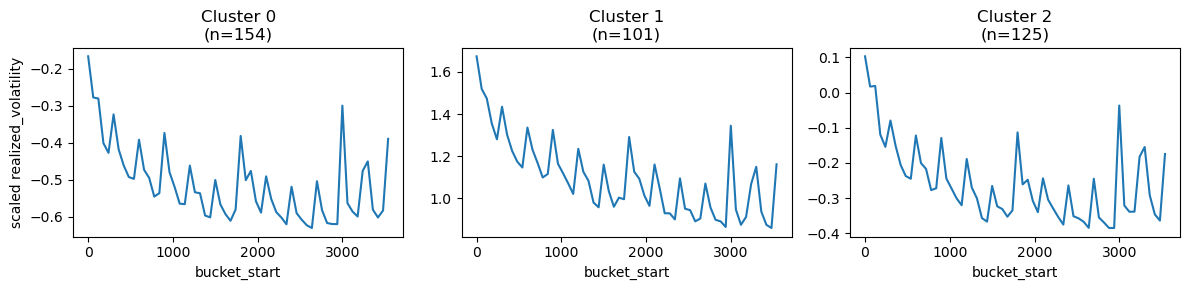

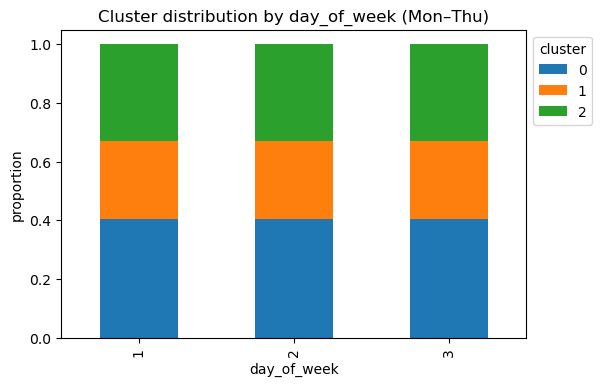

In [71]:

# Plot cluster centroids for realized_volatility
plt.figure(figsize=(4*best_k, 3))
for c in range(best_k):
    mask = labels == c
    # mean pattern of realized_volatility channel
    fidx = features.index("realized_volatility")
    avg_pattern = X_scaled[mask, :, fidx].mean(axis=0)
    plt.subplot(1, best_k, c+1)
    plt.plot(buckets, avg_pattern)
    plt.title(f'Cluster {c}\n(n={mask.sum()})')
    plt.xlabel('bucket_start')
    if c==0:
        plt.ylabel('scaled realized_volatility')
plt.tight_layout()
plt.show()

# Plot cluster distribution by day_of_week for train set
cluster_df2 = df_60s[df_60s['day_of_week'].isin([0,1,2,3])]
dist = pd.crosstab(cluster_df2['day_of_week'], cluster_df2['cluster'], normalize='index')
dist.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('Cluster distribution by day_of_week (Mon–Thu)')
plt.xlabel('day_of_week')
plt.ylabel('proportion')
plt.legend(title='cluster', bbox_to_anchor=(1,1))
plt.show()

In [72]:
df_60s

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,...,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week,cluster
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,...,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,...,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,...,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,...,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,...,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,104919.0,1187.0,3300,-0.000011,0.000061,-0.000685,0.002559,0.000473,0.021667,-0.040270,...,1.174866,0.000070,-0.000014,2021-10-05,16:00:00,190,5,Friday,38,0
683996,104919.0,1187.0,3360,0.000003,0.000040,0.000154,0.001720,0.000309,0.020667,0.131692,...,1.540810,0.000038,0.000011,2021-10-05,16:00:00,190,5,Friday,38,0
683997,104919.0,1187.0,3420,0.000007,0.000060,0.000419,0.002265,0.000468,0.021833,0.094141,...,1.548123,0.000054,0.000034,2021-10-05,16:00:00,190,5,Friday,38,0
683998,104919.0,1187.0,3480,-0.000009,0.000059,-0.000531,0.002406,0.000459,0.021833,-0.013711,...,1.346906,0.000046,-0.000011,2021-10-05,16:00:00,190,5,Friday,38,0


In [75]:
train

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
0,8382.0,12.0,0,-0.000027,0.000360,-0.001583,0.014144,0.002729,0.376897,0.095793,24890.0,3.983192,0.000303,0.000132,2021-01-05,11:00:00,1,1,Monday,1
1,8382.0,12.0,60,0.000005,0.000223,0.000312,0.008965,0.001711,0.305250,0.128977,18721.0,5.989592,0.000235,0.000044,2021-01-05,11:00:00,1,1,Monday,1
2,8382.0,12.0,120,0.000029,0.000187,0.001738,0.007604,0.001453,0.360833,0.008997,18513.0,3.119304,0.000103,0.000053,2021-01-05,11:00:00,1,1,Monday,1
3,8382.0,12.0,180,-0.000008,0.000215,-0.000467,0.007326,0.001650,0.301833,0.031202,35827.0,4.447586,0.000012,0.000025,2021-01-05,11:00:00,1,1,Monday,1
4,8382.0,12.0,240,0.000050,0.000189,0.002992,0.008347,0.001500,0.291500,-0.074440,41679.0,3.859149,0.000116,-0.000091,2021-01-05,11:00:00,1,1,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683635,104919.0,1181.0,3300,0.000042,0.000092,0.002544,0.004675,0.000777,0.021667,0.228900,208144.0,2.478687,0.000094,0.000060,2021-10-04,16:00:00,189,4,Thursday,38
683636,104919.0,1181.0,3360,0.000005,0.000062,0.000298,0.002569,0.000479,0.022333,0.143210,276622.0,1.926057,0.000051,0.000006,2021-10-04,16:00:00,189,4,Thursday,38
683637,104919.0,1181.0,3420,0.000005,0.000101,0.000284,0.004257,0.000776,0.021167,0.005530,276454.0,1.241620,0.000045,0.000000,2021-10-04,16:00:00,189,4,Thursday,38
683638,104919.0,1181.0,3480,0.000007,0.000066,0.000397,0.002610,0.000507,0.021833,0.035270,318932.0,1.636986,0.000013,0.000006,2021-10-04,16:00:00,189,4,Thursday,38


In [76]:
test

,stock_id,time_id,bucket_start,log_ret_mean,log_ret_std,log_ret_sum,abs_volatility,realized_volatility,spread,imbalance,depth,depth_ratio,rv_rolling,mom_rolling,date,time,day,day_of_week,day_name,week
1440,8382.0,36.0,0,-0.000039,0.000398,-0.002262,0.017007,0.003016,0.379224,-0.463014,31676.0,1.100557,0.000190,-0.000008,2021-01-11,11:00:00,5,5,Friday,1
1441,8382.0,36.0,60,-0.000015,0.000282,-0.000921,0.012010,0.002167,0.358667,0.109190,34189.0,25.326880,0.000351,-0.000142,2021-01-11,11:00:00,5,5,Friday,1
1442,8382.0,36.0,120,0.000015,0.000397,0.000897,0.017325,0.003051,0.380167,-0.218332,19842.0,2.575445,0.000336,0.000078,2021-01-11,11:00:00,5,5,Friday,1
1443,8382.0,36.0,180,-0.000001,0.000256,-0.000066,0.009691,0.001969,0.364000,-0.160622,17657.0,2.497647,0.000201,0.000003,2021-01-11,11:00:00,5,5,Friday,1
1444,8382.0,36.0,240,0.000031,0.000457,0.001875,0.019706,0.003522,0.413750,-0.165097,30711.0,3.475366,0.000710,-0.000157,2021-01-11,11:00:00,5,5,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,104919.0,1187.0,3300,-0.000011,0.000061,-0.000685,0.002559,0.000473,0.021667,-0.040270,301254.0,1.174866,0.000070,-0.000014,2021-10-05,16:00:00,190,5,Friday,38
683996,104919.0,1187.0,3360,0.000003,0.000040,0.000154,0.001720,0.000309,0.020667,0.131692,329777.0,1.540810,0.000038,0.000011,2021-10-05,16:00:00,190,5,Friday,38
683997,104919.0,1187.0,3420,0.000007,0.000060,0.000419,0.002265,0.000468,0.021833,0.094141,416248.0,1.548123,0.000054,0.000034,2021-10-05,16:00:00,190,5,Friday,38
683998,104919.0,1187.0,3480,-0.000009,0.000059,-0.000531,0.002406,0.000459,0.021833,-0.013711,380014.0,1.346906,0.000046,-0.000011,2021-10-05,16:00:00,190,5,Friday,38


In [ ]:
df_60s.to_parquet("test.parquet", index=False)
df_60s.to_parquet("df_60s.parquet", index=False)
